# VGG-11

In [52]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import pandas as pd
from PIL import Image
import os

class MitosisDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label
    
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG-11 expects 224x224 inputs
    transforms.ToTensor(),
])

# Assuming 'training images' is your directory and 'Train.csv' is your label file
# train_dataset = MitosisDataset(csv_file='Train.csv', root_dir='Training Images', transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

# # 2. Model Setup
# model = models.vgg11(pretrained=True)  # Load a pre-trained VGG-11 model

# # Modify the final layer to match the number of classes in your dataset
# num_classes = 2  # Mitosis vs Normal
# model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # 3. Training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# for epoch in range(10):  # Loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 200 == 199:  # Print every 200 mini-batches
#             print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200}')
#             running_loss = 0.0

# print('Finished Training')

# 4. Evaluation (Optional)
# Here, you could load your test dataset and evaluate the model's performance similarly to how training is done, but with no backpropagation or weight update steps.


# CNN

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

# Load the labels
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)

# Assuming 'name' column contains image filenames and 'label' column contains the labels
image_files = df['Image'].values
image_files = [f"{name}.jpg" for name in image_files]
labels = df['Label'].values

# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform
        self.label_mapping = {
            'Normal': 0,
            'Mitosis': 1
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label_text = self.labels[idx]
        label = self.label_mapping[label_text]
        label_tensor = torch.tensor(label, dtype=torch.float32)
        
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB

        if self.transform:
            image = self.transform(image)
        
        return image, label_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = SimpleCNN()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        labels = labels.float().unsqueeze(1)  # Adjust labels shape for BCELoss
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation loop (optional, for evaluating model performance)
    model.eval()
    with torch.no_grad():
        # Similar validation loop as training
        pass

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

KeyboardInterrupt: 

# Test Data Predictions using CNN

In [6]:
class TestDataset(Dataset):
    def __init__(self, image_paths, directory, transform=None):
        self.image_paths = image_paths
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

test_df = pd.read_csv('Test.csv')
test_image_files = test_df['Image'].values
test_image_files = [f"{name}.jpg" for name in test_image_files]

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [5]:
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Map numeric predictions back to textual form
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in predictions]

KeyboardInterrupt: 

In [ ]:
# Update the DataFrame with the predictions
test_df['Label'] = textual_predictions

# Save the updated DataFrame to a new CSV file
test_df.to_csv('Test_Predictions.csv', index=False)

All the predictions were 'Normal' which makes me thing the training data was biased. Let's check!

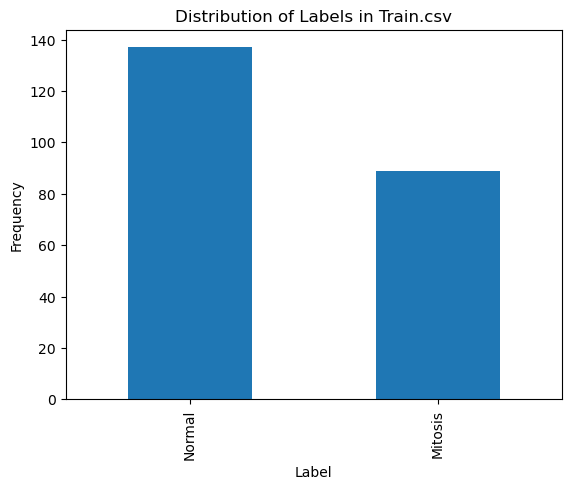

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training data
df = pd.read_csv('Train.csv')

# Plot the distribution of labels
df['Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in Train.csv')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

So, yes. There was biasness. Now, let's re-make the model.

# CNN with image augmentationm weighted loss

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)
image_files = [f"{name}.jpg" for name in df['Image'].values]
labels = df['Label'].values

# Encode labels
label_mapping = {'Normal': 0, 'Mitosis': 1}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Split the dataset
train_files, val_files, train_labels, val_labels = train_test_split(image_files, encoded_labels, test_size=0.2, random_state=42)

# Dataset class with augmentation
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = SimpleCNN()
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            # For metrics calculation
            train_preds += torch.round(torch.sigmoid(outputs)).squeeze().tolist()
            train_targets += labels.tolist()
        
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        # Validation phase
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_preds += torch.round(torch.sigmoid(outputs)).squeeze().tolist()
                val_targets += labels.tolist()
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 0.8741, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 2/10, Loss: 0.7918, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 3/10, Loss: 0.8328, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 4/10, Loss: 0.8323, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 5/10, Loss: 0.7714, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 6/10, Loss: 0.8126, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 7/10, Loss: 0.8120, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 8/10, Loss: 0.7913, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 9/10, Loss: 0.8328, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667
Epoch 10/10, Loss: 0.8126, Train Acc: 0.4167, Train F1: 0.5882, Val Acc: 0.3043, Val F1: 0.4667


In [56]:
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Map numeric predictions back to textual form
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
textual_predictions = [label_mapping_inverse[pred] for pred in predictions]

In [58]:
# Update the DataFrame with the predictions
test_df['Label'] = textual_predictions

# Save the updated DataFrame to a new CSV file
test_df.to_csv('Test_Predictions.csv', index=False)

# DenseNet

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Modify the classifier for binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)  # Output layer for binary classification

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion with class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function adapted for DenseNet
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_preds += torch.round(torch.sigmoid(outputs)).squeeze().tolist()
            train_targets += labels.tolist()
        
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds)

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_preds += torch.round(torch.sigmoid(outputs)).squeeze().tolist()
                val_targets += labels.tolist()
        
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Fatima Azfar/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:13<00:00, 2.31MB/s]


Epoch 1/10, Loss: 0.4488, Train Acc: 0.7111, Train F1: 0.6533, Val Acc: 0.7174, Val F1: 0.6286
Epoch 2/10, Loss: 0.5309, Train Acc: 0.7944, Train F1: 0.7784, Val Acc: 0.7174, Val F1: 0.5806
Epoch 3/10, Loss: 0.4034, Train Acc: 0.8389, Train F1: 0.7914, Val Acc: 0.8696, Val F1: 0.7857
Epoch 4/10, Loss: 0.3453, Train Acc: 0.8056, Train F1: 0.7879, Val Acc: 0.8478, Val F1: 0.7407
Epoch 5/10, Loss: 0.2446, Train Acc: 0.8389, Train F1: 0.8027, Val Acc: 0.8478, Val F1: 0.6957
Epoch 6/10, Loss: 0.4118, Train Acc: 0.8167, Train F1: 0.7898, Val Acc: 0.8478, Val F1: 0.7200
Epoch 7/10, Loss: 0.3725, Train Acc: 0.8556, Train F1: 0.8243, Val Acc: 0.8478, Val F1: 0.7200
Epoch 8/10, Loss: 0.2964, Train Acc: 0.8667, Train F1: 0.8442, Val Acc: 0.8478, Val F1: 0.7407
Epoch 9/10, Loss: 0.2247, Train Acc: 0.8889, Train F1: 0.8734, Val Acc: 0.8043, Val F1: 0.6897
Epoch 10/10, Loss: 0.3074, Train Acc: 0.8944, Train F1: 0.8725, Val Acc: 0.6957, Val F1: 0.6111


In [68]:
class TestDataset(Dataset):
    def __init__(self, image_paths, directory, transform=None):
        self.image_paths = image_paths
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Assuming 'Test Images' directory and 'Test.csv' with an 'Image' column
test_df = pd.read_csv('Test.csv')
test_image_files = [f"{name}.jpg" for name in test_df['Image'].values]

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = TestDataset(test_image_files, 'Testing Images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [69]:
model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).squeeze()
        predicted_labels = torch.round(preds).cpu().numpy()  # Convert to binary labels
        predictions.extend(predicted_labels)

# Map numeric predictions back to label names
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
predicted_labels_text = [label_mapping_inverse[int(pred)] for pred in predictions]

In [70]:
# Update the DataFrame with predictions
test_df['Label'] = predicted_labels_text

# Save the updated DataFrame
test_df.to_csv('Test_Preds.csv', index=False)

Kaggle Submission Result: 70.58% Accuracy

# DenseNet with Enhancements
Best Model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image
import copy
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# Load the dataset
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)
image_files = [f"{name}.jpg" for name in df['Image'].values]
labels = df['Label'].values

# Encode labels
label_mapping = {'Normal': 0, 'Mitosis': 1}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Split the dataset
train_files, val_files, train_labels, val_labels = train_test_split(image_files, encoded_labels, test_size=0.2, random_state=42)

# Dataset class with augmentation
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Modify the classifier for binary classification and add dropout
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Implement Focal Loss instead of weighted BCE
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

criterion = FocalLoss().to(device)

# Optimizer with learning rate scheduling
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            preds_list = []
            targets_list = []

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs).squeeze()
                    loss = criterion(outputs, labels.unsqueeze(1))

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                preds_binary = torch.round(preds).detach().cpu().numpy()
                preds_list.extend(preds_binary)
                targets_list.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = accuracy_score(targets_list, preds_list)
            epoch_f1 = f1_score(targets_list, preds_list)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val F1: {:4f}'.format(best_f1))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15)

['67.jpg', '55.jpg', '124.jpg', '127.jpg', '209.jpg', '84.jpg', '93.jpg', '97.jpg', '115.jpg', '38.jpg', '24.jpg', '119.jpg', '183.jpg', '194.jpg', '10.jpg', '69.jpg', '29.jpg', '19.jpg', '108.jpg', '66.jpg', '73.jpg', '5.jpg', '56.jpg', '112.jpg', '137.jpg', '135.jpg', '65.jpg', '140.jpg', '190.jpg', '224.jpg', '31.jpg', '12.jpg', '35.jpg', '28.jpg', '42.jpg', '125.jpg', '113.jpg', '153.jpg', '51.jpg', '181.jpg', '180.jpg', '76.jpg', '41.jpg', '95.jpg', '138.jpg', '78.jpg', '156.jpg', '26.jpg', '205.jpg', '189.jpg', '126.jpg', '0.jpg', '2.jpg', '77.jpg', '46.jpg', '100.jpg', '109.jpg', '136.jpg', '162.jpg', '90.jpg', '85.jpg', '159.jpg', '150.jpg', '98.jpg', '36.jpg', '132.jpg', '61.jpg', '22.jpg', '147.jpg', '158.jpg', '33.jpg', '11.jpg', '220.jpg', '177.jpg', '6.jpg', '27.jpg', '139.jpg', '216.jpg', '217.jpg', '154.jpg', '4.jpg', '122.jpg', '32.jpg', '161.jpg', '62.jpg', '128.jpg', '212.jpg', '170.jpg', '70.jpg', '173.jpg', '64.jpg', '44.jpg', '146.jpg', '40.jpg', '123.jpg', '23.jpg

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
----------
['67.jpg', '55.jpg', '124.jpg', '127.jpg', '209.jpg', '84.jpg', '93.jpg', '97.jpg', '115.jpg', '38.jpg', '24.jpg', '119.jpg', '183.jpg', '194.jpg', '10.jpg', '69.jpg', '29.jpg', '19.jpg', '108.jpg', '66.jpg', '73.jpg', '5.jpg', '56.jpg', '112.jpg', '137.jpg', '135.jpg', '65.jpg', '140.jpg', '190.jpg', '224.jpg', '31.jpg', '12.jpg', '35.jpg', '28.jpg', '42.jpg', '125.jpg', '113.jpg', '153.jpg', '51.jpg', '181.jpg', '180.jpg', '76.jpg', '41.jpg', '95.jpg', '138.jpg', '78.jpg', '156.jpg', '26.jpg', '205.jpg', '189.jpg', '126.jpg', '0.jpg', '2.jpg', '77.jpg', '46.jpg', '100.jpg', '109.jpg', '136.jpg', '162.jpg', '90.jpg', '85.jpg', '159.jpg', '150.jpg', '98.jpg', '36.jpg', '132.jpg', '61.jpg', '22.jpg', '147.jpg', '158.jpg', '33.jpg', '11.jpg', '220.jpg', '177.jpg', '6.jpg', '27.jpg', '139.jpg', '216.jpg', '217.jpg', '154.jpg', '4.jpg', '122.jpg', '32.jpg', '161.jpg', '62.jpg', '128.jpg', '212.jpg', '170.jpg', '70.jpg', '173.jpg', '64.jpg', '44.jpg', '146.jpg', '40.jp

KeyboardInterrupt: 

In [3]:
model_save_path = 'denseNet_2.pth'
torch.save(model.state_dict(), model_save_path)

In [7]:
model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).squeeze()
        predicted_labels = torch.round(preds).cpu().numpy()  # Convert to binary labels
        predictions.extend(predicted_labels)

# Map numeric predictions back to label names
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
predicted_labels_text = [label_mapping_inverse[int(pred)] for pred in predictions]

In [8]:
# Update the DataFrame with predictions
test_df['Label'] = predicted_labels_text

# Save the updated DataFrame
test_df.to_csv('Test_Preds_7.csv', index=False)

Kaggle Submission Result: 

Test_Preds_2.csv: 83.87% Accuracy

Test_Preds_4.csv: 68%

Test_Preds_5.csv: 87.5%

Test_Preds_6.csv: 68%

Test_Preds_5.csv: 87.5% (model file: DenseNet_2.pth)

# Updates Made:
- Advanced Data Augmentation
- Dynamic Learning Rate Adjustment: OneCycleLR scheduler, for more aggressive learning rate management.
- Regularization and Fine-tuning Strategy: weight decay in the optimizer for regularization.

In [9]:
from torchvision import models, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import copy
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.class_weights is not None:
            class_weights = self.class_weights[targets.long()]
            F_loss *= class_weights

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

criterion = FocalLoss(alpha=1, gamma=2, reduction='mean', class_weights=class_weights_tensor).to(device)

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Total steps calculation for OneCycleLR
EPOCHS = 10
train_steps = len(train_loader.dataset) // train_loader.batch_size
total_steps = train_steps * EPOCHS

# OneCycleLR Scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            preds_list = []
            targets_list = []

            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).detach().cpu()
                preds_binary = torch.round(preds).numpy()
                preds_list.extend(preds_binary.flatten())
                targets_list.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = accuracy_score(targets_list, preds_list)
            epoch_f1 = f1_score(targets_list, preds_list)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val F1: {:4f}'.format(best_f1))
    model.load_state_dict(best_model_wts)
    return model

# Proceed with training
model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, EPOCHS)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 0.2236 Acc: 0.6833 F1: 0.6587
Val Loss: 0.9096 Acc: 0.7174 F1: 0.1333
Epoch 2/10
----------
Train Loss: 0.1922 Acc: 0.7167 F1: 0.6832
Val Loss: 360.2284 Acc: 0.6957 F1: 0.0000
Epoch 3/10
----------
Train Loss: 0.2170 Acc: 0.6944 F1: 0.6584
Val Loss: 5679.0238 Acc: 0.6957 F1: 0.0000
Epoch 4/10
----------
Train Loss: 0.4595 Acc: 0.5722 F1: 0.5217
Val Loss: 235.4202 Acc: 0.3043 F1: 0.4667
Epoch 5/10
----------
Train Loss: 0.3051 Acc: 0.5278 F1: 0.5029
Val Loss: 147.6438 Acc: 0.3043 F1: 0.4667
Epoch 6/10
----------
Train Loss: 0.2520 Acc: 0.6611 F1: 0.5960
Val Loss: 89.6990 Acc: 0.6957 F1: 0.0000
Epoch 7/10
----------
Train Loss: 0.1398 Acc: 0.7556 F1: 0.7250
Val Loss: 7.1451 Acc: 0.7826 F1: 0.6429
Epoch 8/10
----------
Train Loss: 0.2005 Acc: 0.7389 F1: 0.7251
Val Loss: 0.1518 Acc: 0.7826 F1: 0.6667
Epoch 9/10
----------
Train Loss: 0.2235 Acc: 0.7667 F1: 0.7273
Val Loss: 0.1477 Acc: 0.7391 F1: 0.6250
Epoch 10/10
----------
Train Loss: 0.1462 Acc: 0.7944 

In [76]:
model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).squeeze()
        predicted_labels = torch.round(preds).cpu().numpy()  # Convert to binary labels
        predictions.extend(predicted_labels)

# Map numeric predictions back to label names
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
predicted_labels_text = [label_mapping_inverse[int(pred)] for pred in predictions]

In [77]:
# Update the DataFrame with predictions
test_df['Label'] = predicted_labels_text

# Save the updated DataFrame
test_df.to_csv('Test_Preds_3.csv', index=False)

Kaggle Submission Result: 78.78% Accuracy

# VGG-11

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from PIL import Image
import copy

# Load the labels
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)

# Assuming 'name' column contains image filenames and 'label' column contains the labels
image_files = df['Image'].values
image_files = [f"{name}.jpg" for name in image_files]
labels = df['Label'].values

# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform
        self.label_mapping = {
            'Normal': 0,
            'Mitosis': 1
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label_text = self.labels[idx]
        label = self.label_mapping[label_text]
        label_tensor = torch.tensor(label, dtype=torch.float32)
        
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB

        if self.transform:
            image = self.transform(image)
        
        return image, label_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VGG-11 model and modify it for binary classification
model = models.vgg11(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Changing to 1 output feature
model = model.to(device)

# Implement Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

criterion = FocalLoss().to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            preds_list = []
            targets_list = []

            for inputs, labels in data_loader:  # Correctly using data_loader here
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)  # Ensure labels are float and correctly shaped

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds_binary = torch.sigmoid(outputs.detach()).cpu().numpy() > 0.5
                preds_list.extend(preds_binary.flatten())
                targets_list.extend(labels.cpu().numpy().flatten())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = accuracy_score(targets_list, preds_list)
            epoch_f1 = f1_score(targets_list, preds_list)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val F1: {best_f1:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Call train_model function with the defined loaders and parameters
model_trained = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 0.6133 Acc: 0.5722 F1: 0.4539
Val Loss: 0.3738 Acc: 0.3043 F1: 0.4667
Epoch 2/10
----------
Train Loss: 0.2460 Acc: 0.4722 F1: 0.2963
Val Loss: 0.1659 Acc: 0.6957 F1: 0.0000
Epoch 3/10
----------
Train Loss: 0.1743 Acc: 0.5444 F1: 0.3971
Val Loss: 0.1584 Acc: 0.6087 F1: 0.5909
Epoch 4/10
----------
Train Loss: 0.1803 Acc: 0.5556 F1: 0.2982
Val Loss: 0.1715 Acc: 0.6957 F1: 0.0000
Epoch 5/10
----------
Train Loss: 0.1955 Acc: 0.4722 F1: 0.4693
Val Loss: 0.1775 Acc: 0.6957 F1: 0.0000
Epoch 6/10
----------
Train Loss: 0.1949 Acc: 0.5167 F1: 0.2927
Val Loss: 0.1873 Acc: 0.3043 F1: 0.4667
Epoch 7/10
----------
Train Loss: 0.1813 Acc: 0.4944 F1: 0.3358
Val Loss: 0.1556 Acc: 0.6957 F1: 0.0000
Epoch 8/10
----------
Train Loss: 0.1739 Acc: 0.5833 F1: 0.0000
Val Loss: 0.1564 Acc: 0.6957 F1: 0.0000
Epoch 9/10
----------
Train Loss: 0.1740 Acc: 0.5833 F1: 0.0000
Val Loss: 0.1605 Acc: 0.6957 F1: 0.0000
Epoch 10/10
----------
Train Loss: 0.1733 Acc: 0.5500 F1: 0.0241

So far, DenseNet has been the only model good enough, so I am now going to focus on boosting that model.

# DenseNet Further Improvement

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image
import copy
import optuna

# Assuming device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming FocalLoss is defined
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Load the dataset
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)
image_files = [f"{name}.jpg" for name in df['Image'].values]
labels = df['Label'].values

# Encode labels
label_mapping = {'Normal': 0, 'Mitosis': 1}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Split the dataset
train_files, val_files, train_labels, val_labels = train_test_split(image_files, encoded_labels, test_size=0.2, random_state=42)

# Dataset class with augmentation
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Define transforms with augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)


def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    # Model setup
    from torchvision.models import densenet121, DenseNet121_Weights
    weights = DenseNet121_Weights.DEFAULT
    model = densenet121(weights=weights)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, 1),
    )
    model = model.to(device)

    criterion = FocalLoss().to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training loop simplified for hyperparameter optimization
    best_f1 = 0.0
    for epoch in range(3):  # Reduced number of epochs for faster trials
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)  # Ensure correct shape for binary classification

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        preds_list = []
        targets_list = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                preds_list.extend(preds.flatten())
                targets_list.extend(labels.cpu().numpy().flatten())

        epoch_f1 = f1_score(targets_list, preds_list)
        best_f1 = max(best_f1, epoch_f1)

    return best_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Reduced number of trials for demonstration

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-02-14 18:36:19,817] A new study created in memory with name: no-name-71b66d11-f7b7-4599-a24c-8d2bcda3b5e2
[I 2024-02-14 18:40:27,612] Trial 0 finished with value: 0.64 and parameters: {'lr': 0.004040071357405934, 'dropout_rate': 0.3417845042007459}. Best is trial 0 with value: 0.64.
[I 2024-02-14 18:44:36,974] Trial 1 finished with value: 0.0 and parameters: {'lr': 0.04148570617003899, 'dropout_rate': 0.42128452149567486}. Best is trial 0 with value: 0.64.
[I 2024-02-14 18:48:50,399] Trial 2 finished with value: 0.6956521739130435 and parameters: {'lr': 0.001692624100690747, 'dropout_rate': 0.2735016071475943}. Best is trial 2 with value: 0.6956521739130435.
[I 2024-02-14 18:53:01,727] Trial 3 finished with value: 0.7407407407407408 and parameters: {'lr': 0.00033025381326290735, 'dropout_rate': 0.42137885749872317}. Best is trial 3 with value: 0.7407407407407408.
[I 2024-02-14 18:57:12,628] Trial 4 finished with value: 0.6451612903225806 and parameters: {'lr': 4.196535504557435

Best trial:
Value: 0.75
Params: 
lr: 0.0007182771568338171
dropout_rate: 0.28059402905324304


# DenseNet with the following updates:
- Adding more data augmentation techniques i.e color jittering, vertical flip, image resizing
- Adding weighted sampling mechanism to tackle with imbalance
- Adding ReduceLROnPlateau learning rate scheduling mechanism in place of StepLR
- Adjusting dropout within the model's classifier to prevent overfitting
- Adjusting the Focal Loss to incorporate class weights, making the loss function more sensitive to the minority class

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from PIL import Image
import copy
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# Load the dataset
labels_csv_path = 'Train.csv'
df = pd.read_csv(labels_csv_path)
image_files = [f"{name}.jpg" for name in df['Image'].values]
labels = df['Label'].values

# Encode labels
label_mapping = {'Normal': 0, 'Mitosis': 1}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Split the dataset
train_files, val_files, train_labels, val_labels = train_test_split(image_files, encoded_labels, test_size=0.2, random_state=42)

# Dataset class with augmentation
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, directory, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        assert idx < len(self.image_paths), f"Index {idx} out of range."
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        img_path = f"{self.directory}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Enhanced Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size to allow the model to learn more detailed features
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Added vertical flip
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Focus on different image parts
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
train_dataset = CustomDataset(train_files, train_labels, 'Training Images', transform=transform)
val_dataset = CustomDataset(val_files, val_labels, 'Training Images', transform=transform)

# Calculate weights for each class
class_sample_counts = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
samples_weights = np.array([weights[t] for t in train_labels])

# Create a sampler for weighted sampling
sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Update DataLoader for training set to use the sampler
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Modify the classifier for binary classification and add dropout
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.28059402905324304), # adjusted the dropout rate from 0.5 to 0.6
    nn.Linear(num_ftrs, 1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Adjust FocalLoss to use class weights
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.class_weights is not None:
            class_weights = self.class_weights[targets.long()]
            F_loss *= class_weights

        return torch.mean(F_loss) if self.reduction == 'mean' else torch.sum(F_loss)

# Calculate class weights and update FocalLoss initialization
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean', class_weights=class_weights_tensor).to(device)

# Optimizer with learning rate scheduling
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Optimizer with fine-tuned learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0007182771568338171)  # Adjusted learning rate

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)  # More dynamic adjustment

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            preds_list = []
            targets_list = []

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs).squeeze()
                    loss = criterion(outputs, labels.unsqueeze(1))

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                preds_binary = torch.round(preds).detach().cpu().numpy()
                preds_list.extend(preds_binary)
                targets_list.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = accuracy_score(targets_list, preds_list)
            epoch_f1 = f1_score(targets_list, preds_list)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # if phase == 'val':
            #     scheduler.step(epoch_loss)
            if phase == 'train':
                scheduler.step(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val F1: {:4f}'.format(best_f1))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 0.2101 Acc: 0.6611 F1: 0.6554
Val Loss: 0.2464 Acc: 0.6957 F1: 0.6111
Epoch 2/10
----------
Train Loss: 0.1562 Acc: 0.7667 F1: 0.8073
Val Loss: 0.1613 Acc: 0.7174 F1: 0.6486
Epoch 3/10
----------
Train Loss: 0.1583 Acc: 0.7278 F1: 0.7435
Val Loss: 0.1918 Acc: 0.8261 F1: 0.6364
Epoch 4/10
----------
Train Loss: 0.1048 Acc: 0.8111 F1: 0.8191
Val Loss: 0.3644 Acc: 0.5870 F1: 0.5366
Epoch 5/10
----------
Train Loss: 0.1821 Acc: 0.6944 F1: 0.6927
Val Loss: 0.1492 Acc: 0.6522 F1: 0.5789
Epoch 6/10
----------
Train Loss: 0.1272 Acc: 0.7556 F1: 0.7755
Val Loss: 1.0244 Acc: 0.8261 F1: 0.7143
Epoch 7/10
----------
Train Loss: 0.1513 Acc: 0.8167 F1: 0.8308
Val Loss: 0.2942 Acc: 0.8043 F1: 0.7273
Epoch 8/10
----------
Train Loss: 0.1089 Acc: 0.7833 F1: 0.7958
Val Loss: 0.1230 Acc: 0.6522 F1: 0.5789
Epoch 9/10
----------
Train Loss: 0.1121 Acc: 0.8333 F1: 0.8485
Val Loss: 0.3142 Acc: 0.8043 F1: 0.7097
Epoch 10/10
----------
Train Loss: 0.0940 Acc: 0.8500 F1: 0.8756

In [26]:
model_save_path = 'DN_heavy_aug.pth'
torch.save(model.state_dict(), model_save_path)
# Update the DataFrame with predictions
test_df['Label'] = predicted_labels_text

# Save the updated DataFrame
test_df.to_csv('Test_Preds_7.csv', index=False)

In [27]:
model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).squeeze()
        predicted_labels = torch.round(preds).cpu().numpy()  # Convert to binary labels
        predictions.extend(predicted_labels)

# Map numeric predictions back to label names
label_mapping_inverse = {0: 'Normal', 1: 'Mitosis'}
predicted_labels_text = [label_mapping_inverse[int(pred)] for pred in predictions]

In [28]:
# Update the DataFrame with predictions
test_df['Label'] = predicted_labels_text

# Save the updated DataFrame
test_df.to_csv('Test_Preds_8.csv', index=False)